**Install Required Libraries**

In [ ]:
!pip install requests
!pip install opencv-python
!pip install requests
!pip install tqdm
!pip install scikit-image
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install xgboost

**Import Libraries**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from skimage.feature import hog
from skimage import exposure

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn import metrics

# Set random seed for reproducibility
RANDOM_SEED = 100
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Define image size for resizing
IMG_SIZE = 128

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load image dataset**

In [ ]:
data_folder = '/content/drive/MyDrive/BCU/ CMP7229 Applied AI A S2 2024 5/Week 3/image processing/data'

#/content/drive/MyDrive/BCU/ CMP7229 Applied AI A S2 2024 5/Week 3/image processing

In [ ]:
# load training data
df_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
# df_train = pd.read_csv('https://drive.google.com/uc?export=download&id=1fm16JcmGtOqASNR0ifCL3VJtab8Qx_hR')

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 10000


id label
0   1   cat
1   2   dog
2   3   cat
3   4   cat
4   5   cat

In [ ]:
# load testing data
df_test = pd.read_csv(os.path.join(data_folder, 'test.csv'))
# df_test = pd.read_csv('https://drive.google.com/uc?export=download&id=1Og1CqTtEXHh3gScSST30Qe-y7DB4S7FW')

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 1000


id
0   1
1   2
2   3
3   4
4   5

**Function to Load Images from Folder**

In [ ]:
# method to load images in a folder
def load_images(ids, folder_path, dim=None):
  '''
  ids: list of image ids
  folder_path: path to image folder
  dim: dimensions to resize images (optional)
  '''
  images = []
  for id in tqdm(ids):
    image_path = os.path.join(folder_path, f'{id}.jpg')
    img = cv2.imread(image_path)

    # Resize if necessary
    if dim is not None:
      if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
        img = cv2.resize(img, dim)
    images.append(img)
  return images

**Load Train & Test Images**

In [ ]:
base_dim = (200, 200)

# load train images
train_image_folder = os.path.join(data_folder, 'train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join(data_folder, 'test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

100%|██████████| 10000/10000 [00:54<00:00, 182.87it/s]


Number of training images loaded: 10000


100%|██████████| 1000/1000 [00:05<00:00, 189.69it/s]

Number of testing images loaded: 1000


In [ ]:
# Load CSV files
# Assuming your train.csv and test.csv files are in the data_folder
train_csv_path = os.path.join(data_folder, 'train.csv')
test_csv_path = os.path.join(data_folder, 'test.csv')

In [ ]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [ ]:
train_df.head()

id label
0   1   cat
1   2   dog
2   3   cat
3   4   cat
4   5   cat

In [ ]:
df_test.shape

(1000, 1)

In [ ]:
df_train.isnull().sum()

id       0
label    0
dtype: int64

In [ ]:
df_test.isnull().sum()

id    0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

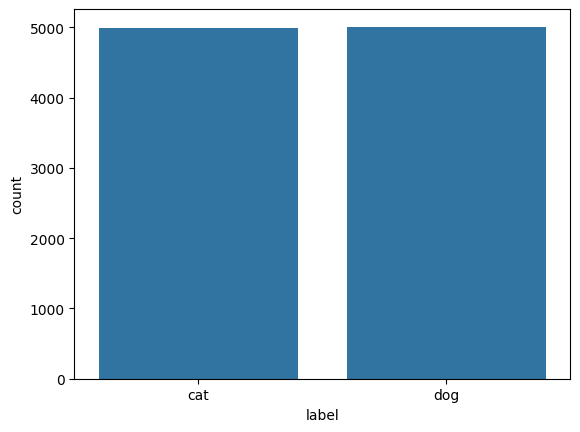

In [ ]:
# Summarise label details in training data
sns.countplot(x=df_train['label'])

#### **Exploratory Data Analysis**

* Inspecting the Dataset

Number of training entries: 10000
   id label
0   1   cat
1   2   dog
2   3   cat
3   4   cat
4   5   cat


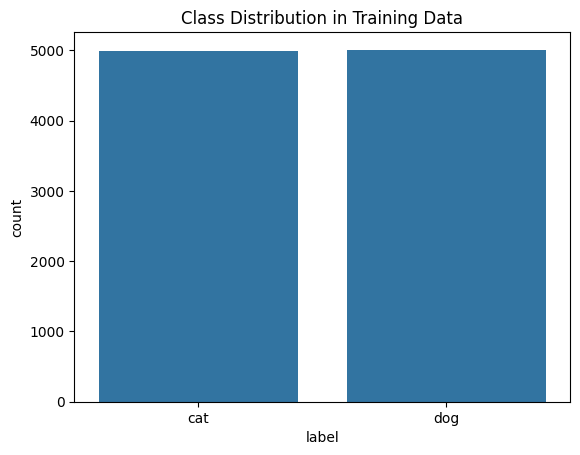

In [ ]:
# Check the number of images and class distribution.
df_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
print("Number of training entries:", len(df_train))
print(df_train.head())

# Plot class distribution
sns.countplot(x=df_train['label'])
plt.title("Class Distribution in Training Data")
plt.show()

From the bar chart, it’s clear that the dataset has nearly the same number of cat and dog images, suggesting a balanced distribution for both classes.

* Visualizing Sample Images

Samples for cat:


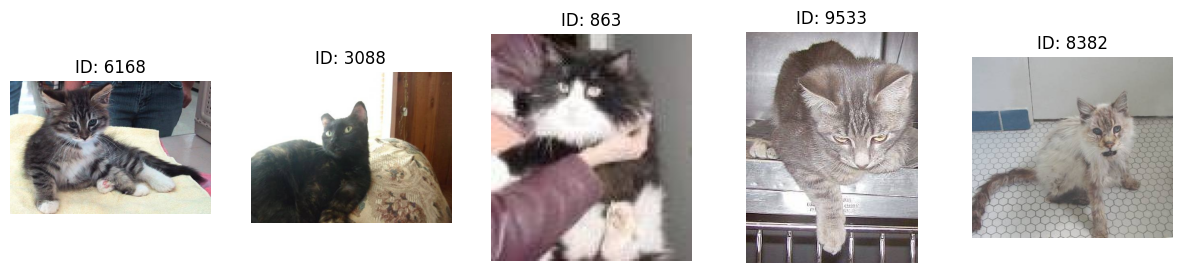

Samples for dog:


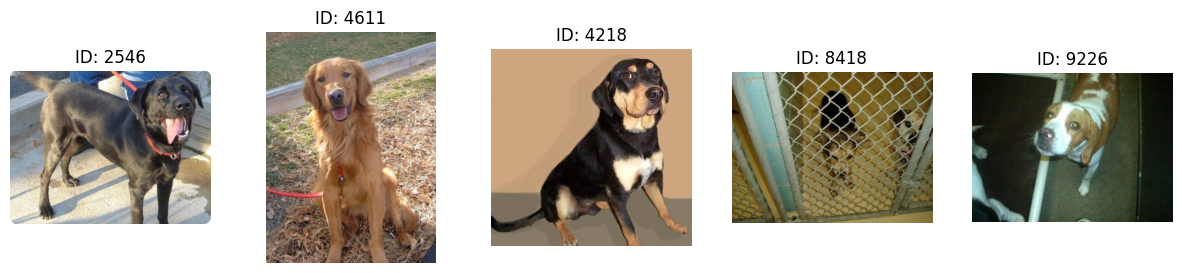

In [ ]:
# Display a few sample images for each class.
def display_samples(df, image_folder, num_samples=5):
    sample_ids = df.sample(num_samples)['id'].tolist()
    plt.figure(figsize=(15, 3))
    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join(image_folder, f'{img_id}.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"ID: {img_id}")
        plt.axis('off')
    plt.show()

# Display samples for each class
for label in df_train['label'].unique():
    print(f"Samples for {label}:")
    display_samples(df_train[df_train['label'] == label], train_image_folder)

These sample images reveal noticeable variations in shape, size, and background. Consequently, standard preprocessing steps (like resizing and normalization) are beneficial to align dimensions and enhance model accuracy.

* Checking Image Dimensions and Quality

Sample image dimensions (height, width, channels): [(200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3)]


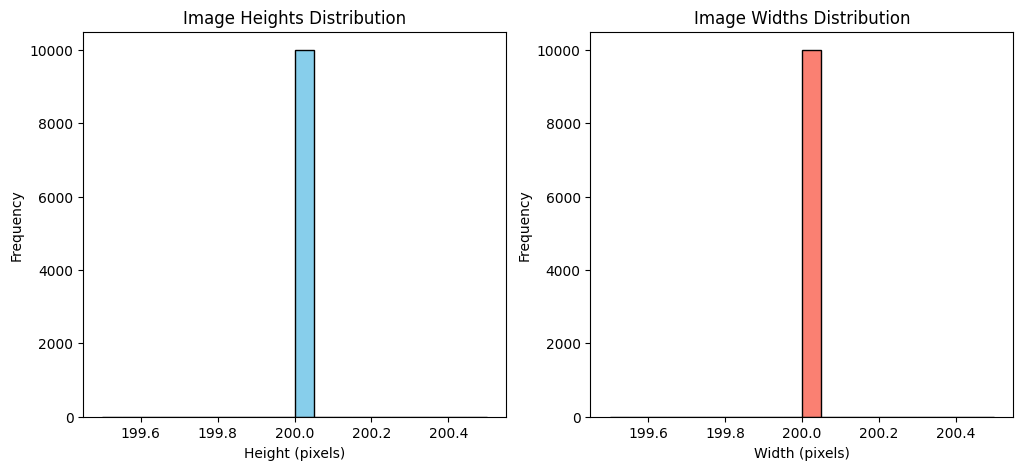

In [ ]:
# Get dimensions of a few images
dimensions = [img.shape for img in train_images[:10]]
print("Sample image dimensions (height, width, channels):", dimensions)

# Plot histogram of image widths and heights
heights = [img.shape[0] for img in train_images]
widths  = [img.shape[1] for img in train_images]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(heights, bins=20, color='skyblue', edgecolor='black')
plt.title("Image Heights Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(widths, bins=20, color='salmon', edgecolor='black')
plt.title("Image Widths Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.show()


All images appear to have uniform dimensions (around 200×200 pixels), meaning little need for dimension-based resizing. This uniformity simplifies subsequent processing steps, as consistent shapes reduce complexity for feature extraction and modeling.

* Pixel Intensity Distribution

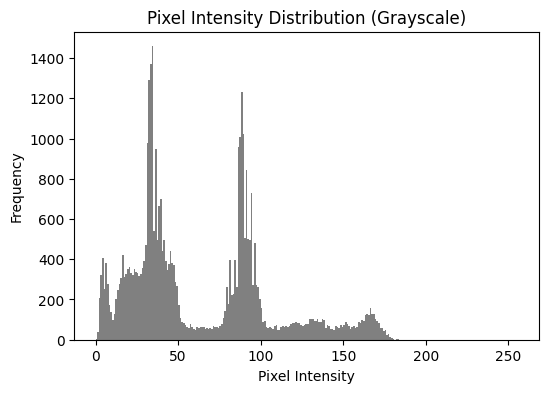

In [ ]:
sample_img = random.choice(train_images)
gray_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6,4))
plt.hist(gray_img.ravel(), bins=256, range=[0,256], color='gray')
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


This histogram reveals multiple peaks in brightness, suggesting the image has a broad range of light and dark areas. Such variation in pixel intensity can help distinguish key features when extracting edges and textures.

*  Feature Visualization

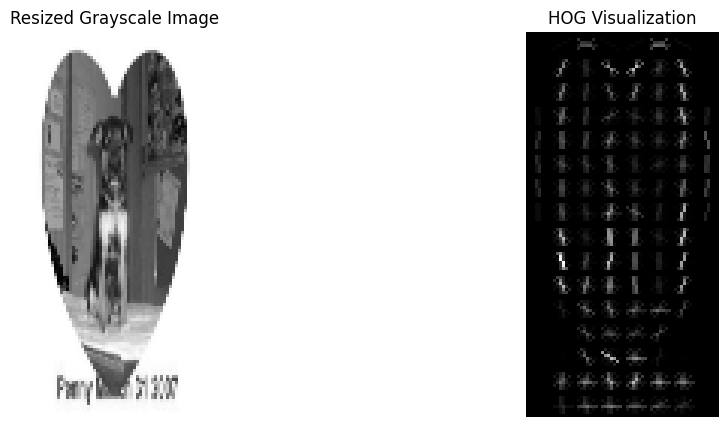

In [ ]:
# Visualize Histogram of Oriented Gradients (HOG) features for a sample image.
sample_img = random.choice(train_images)
gray_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(gray_img, (64, 128))

# Extract HOG features and get the visualization
features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_resized, cmap='gray')
plt.title("Resized Grayscale Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Visualization")
plt.axis('off')
plt.show()


This HOG visualization highlights edges and gradient directions in the image, capturing key shape details that help the model recognize distinct features for classification.

* Analyze Average Brightness and Contrast

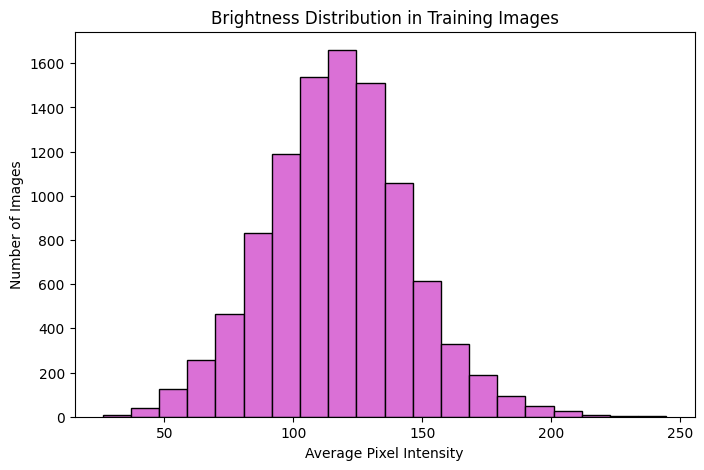

In [ ]:
# Compute and plot the average brightness (mean pixel intensity) for each image.
def compute_brightness(img):
    # Convert to grayscale and compute mean intensity
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# Compute brightness for all training images
brightness_values = [compute_brightness(img) for img in train_images]

plt.figure(figsize=(8,5))
plt.hist(brightness_values, bins=20, color='orchid', edgecolor='black')
plt.title("Brightness Distribution in Training Images")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Number of Images")
plt.show()


Most images cluster around mid-range brightness, indicating they’re neither too dark nor overly bright. This suggests only minimal exposure adjustments might be needed before feature extraction.

* Check Contrast Variation

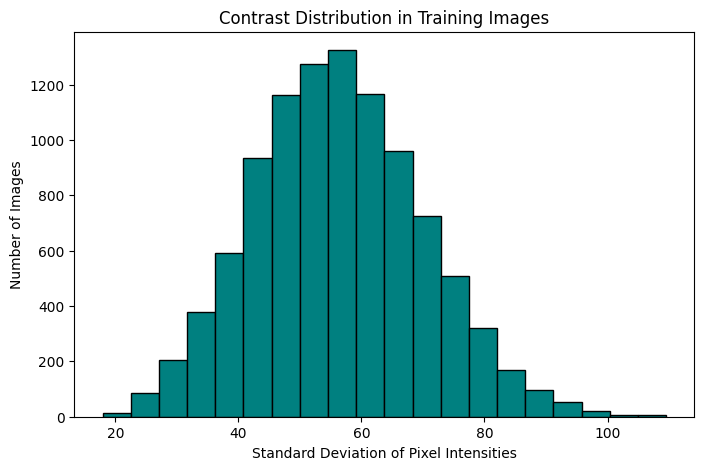

In [ ]:
# Calculate the contrast (standard deviation of pixel intensities) for each image.
def compute_contrast(img):
    # Convert to grayscale and compute standard deviation
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.std(gray)

# Compute contrast for all training images
contrast_values = [compute_contrast(img) for img in train_images]

plt.figure(figsize=(8,5))
plt.hist(contrast_values, bins=20, color='teal', edgecolor='black')
plt.title("Contrast Distribution in Training Images")
plt.xlabel("Standard Deviation of Pixel Intensities")
plt.ylabel("Number of Images")
plt.show()


Most images fall into a moderate contrast range, indicating a balanced spread of light and dark areas. This suggests only a few images might need contrast normalization to enhance feature visibility.

* Visualize Sample Images with Their Brightness and Contrast

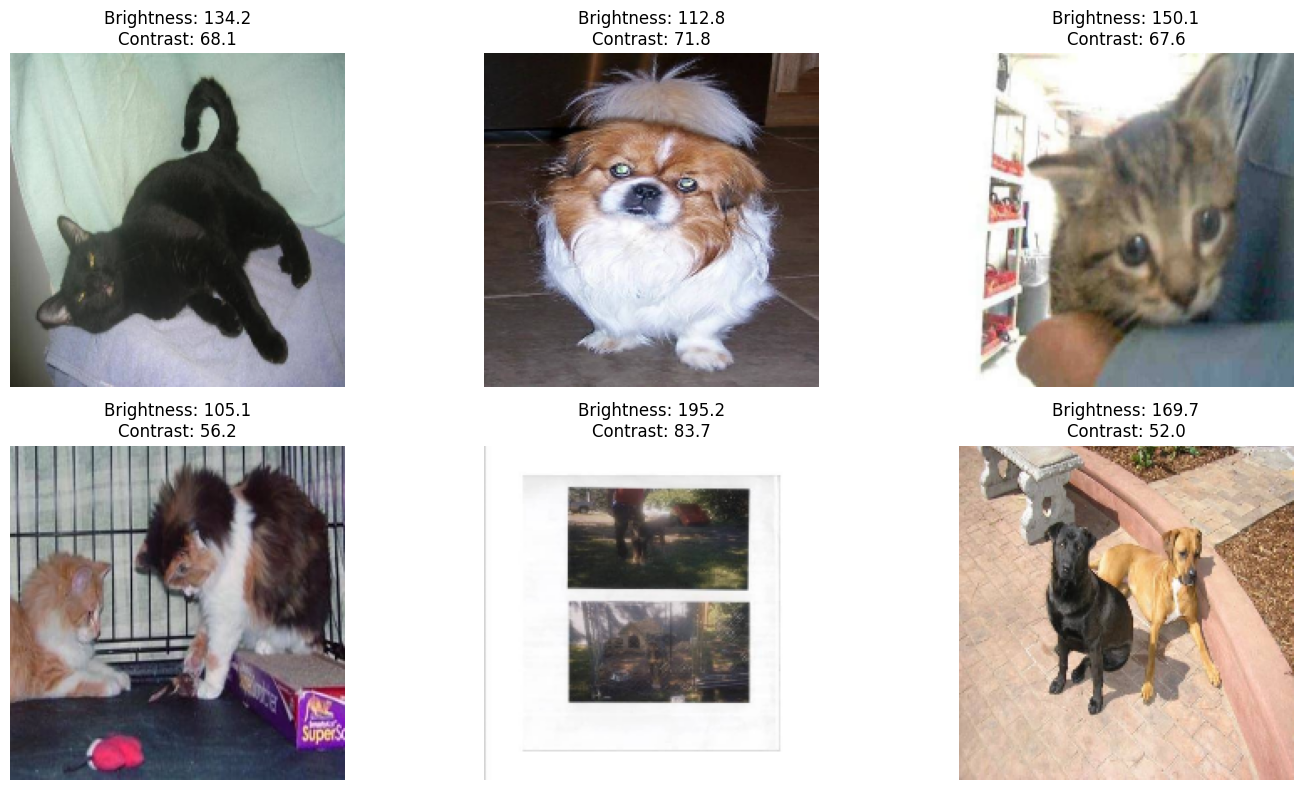

In [ ]:
# Display a few images along with their brightness and contrast values.
sample_indices = np.random.choice(len(train_images), 6, replace=False)
plt.figure(figsize=(15,8))
for i, idx in enumerate(sample_indices):
    img = train_images[idx]
    brightness = compute_brightness(img)
    contrast = compute_contrast(img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i+1)
    plt.imshow(img_rgb)
    plt.title(f"Brightness: {brightness:.1f}\nContrast: {contrast:.1f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


These examples highlight how brightness and contrast can differ significantly between images. Adjusting exposure or applying normalization may help ensure consistent visual features for the model.

* PCA Visualization on Flattened Images

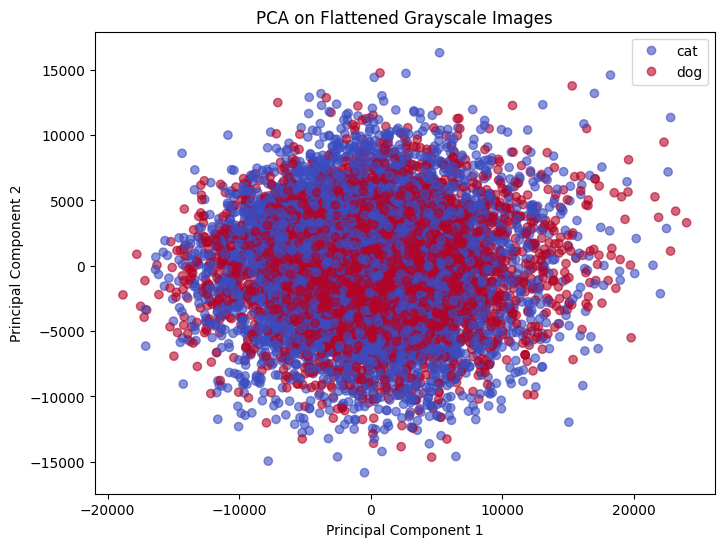

In [ ]:
flat_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in train_images]
flat_images = np.array(flat_images)

# Apply PCA to reduce dimensions to 2
pca_2d = PCA(n_components=2, random_state=RANDOM_SEED)
flat_images_2d = pca_2d.fit_transform(flat_images)

# Map labels (assuming df_train['label'] contains categorical labels like "cat"/"dog")
label_map = {'cat': 0, 'dog': 1}
labels_numeric = df_train['label'].map(label_map).values

plt.figure(figsize=(8,6))
scatter = plt.scatter(flat_images_2d[:, 0], flat_images_2d[:, 1], c=labels_numeric, cmap='coolwarm', alpha=0.6)
plt.title("PCA on Flattened Grayscale Images")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['cat', 'dog'])
plt.show()


The two principal components show considerable overlap between cats and dogs, indicating that raw grayscale pixel data doesn’t strongly separate the classes. Additional feature extraction or preprocessing may be needed for clearer discrimination.

* t-SNE Visualization on HOG Features

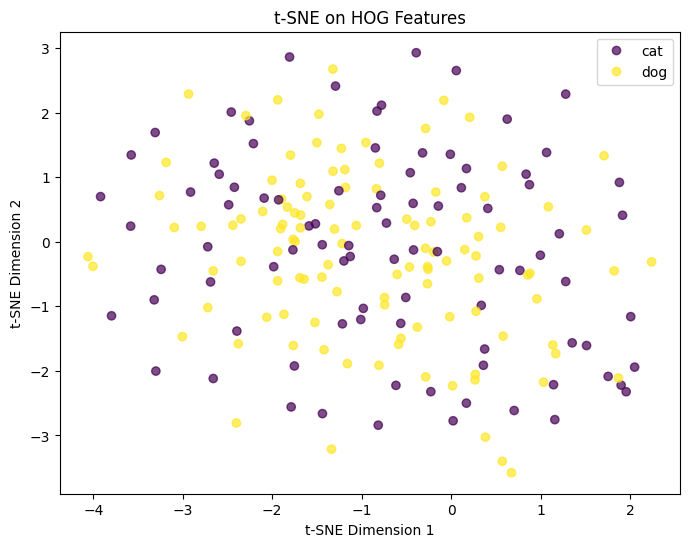

In [ ]:
sample_size = 200
sample_indices = np.random.choice(len(train_images), sample_size, replace=False)
hog_features_sample = []

for idx in sample_indices:
    img = train_images[idx]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray, (64, 128))
    features, _ = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True)
    hog_features_sample.append(features)
hog_features_sample = np.array(hog_features_sample)

# Get corresponding labels
sample_labels = df_train.iloc[sample_indices]['label'].map(label_map).values

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
hog_tsne = tsne.fit_transform(hog_features_sample)

plt.figure(figsize=(8,6))
scatter = plt.scatter(hog_tsne[:, 0], hog_tsne[:, 1], c=sample_labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE on HOG Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['cat', 'dog'])
plt.show()

These HOG features provide partial separation between cats and dogs, but there’s still overlap. Additional feature engineering or advanced models may help further distinguish the two classes.

**Evaluate Model Performance**

In [ ]:
def evaluate(actuals, predictions, class_names):

  # calculate accuracy
  accuracy = metrics.accuracy_score(actuals, predictions)
  print(f'Accuracy: {accuracy}')

  # plot confusion matrix
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
  disp.plot()
  plt.show()

**Train & Predict using SVM**

In [ ]:
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=RANDOM_SEED)
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, clf.classes_)

  return clf

**MODEL 1: Grayscale Image Vectorization (SVM)**

In [ ]:
# method to get image features
def get_features_m1svm(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # image vectorisation/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m1svm = get_features_m1svm(train_images)
print(features_train_m1svm.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m1svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.516


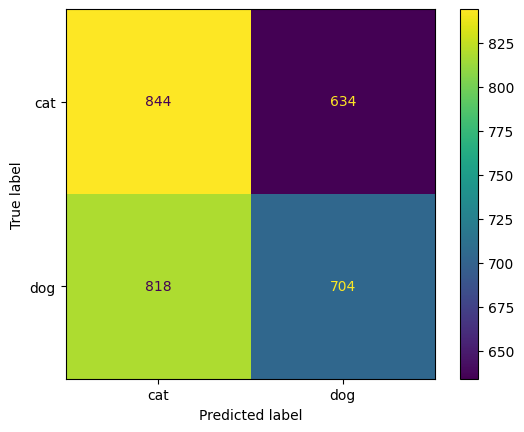

In [ ]:
# train model
m1svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m1svm = get_features_m1svm(test_images)
print(features_test_m1svm.shape)

# get model predictions
predictions_m1svm = m1svm.predict(features_test_m1svm)
#print(predictions)

(1000, 40000)


**M2: Grayscale + Smoothing (Gaussian Blur) (SVM)**

In [ ]:
# method to get image features
def get_features_m2svm(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling + smoothing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled, (3,3), 2)

    # image vectorisation/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m2svm = get_features_m2svm(train_images)
print(features_train_m2svm.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m2svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.513


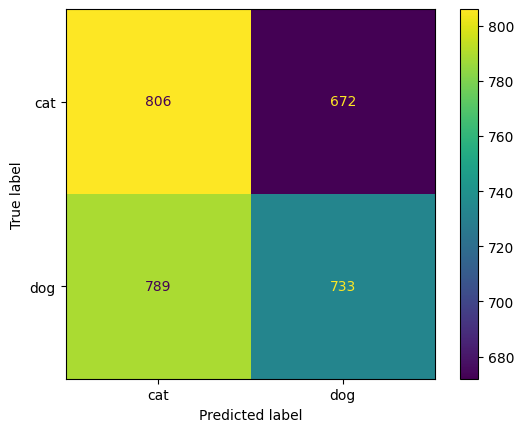

In [ ]:
# train model
m2svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m2svm = get_features_m2svm(test_images)
print(features_test_m2svm.shape)

(1000, 40000)


In [ ]:
# get model predictions
predictions_m2svm = m2svm.predict(features_test_m2svm)
#print(predictions)

**M3: Grayscale + Edge Detection (Canny) (SVM)**

In [ ]:
# method to get image features
def get_features_m3svm(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction - edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m3svm = get_features_m3svm(train_images)
print(features_train_m3svm.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m3svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5753333333333334


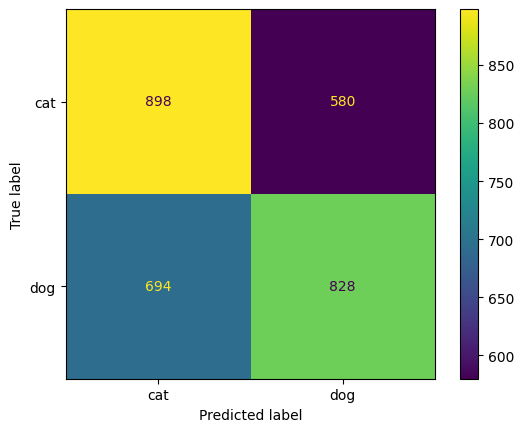

In [ ]:
# train model
m3svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m3svm = get_features_m3svm(test_images)
print(features_test_m3svm.shape)

(1000, 40000)


In [ ]:
# get model predictions
predictions_m3svm = m3svm.predict(features_test_m3svm)
#print(predictions_m3svm)

**M4: Grayscale + HOG Features**

In [ ]:
from skimage.feature import hog

# method to get image features
def get_features_m4svm(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction - HOG
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m4svm = get_features_m4svm(train_images)
print(features_train_m4svm.shape)

(10000, 3780)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m4svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6696666666666666


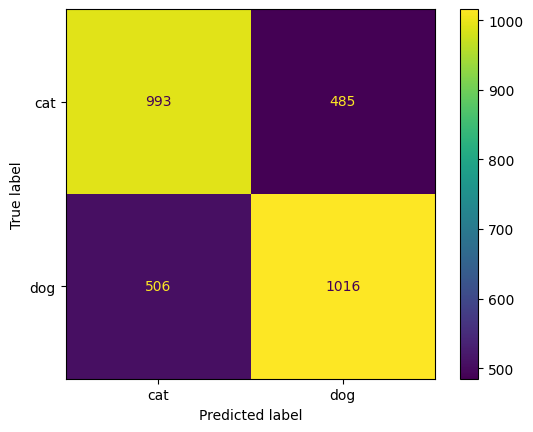

In [ ]:
# train model
m4svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m4svm = get_features_m4svm(test_images)
print(features_test_m4svm.shape)

(1000, 3780)


In [ ]:
# get model predictions
predictions_m4svm = m4svm.predict(features_test_m4svm)
#print(predictions_m4svm)

**M5: Grayscale + Edge Detection + Original Image Features (Concatenation) (SVM)**

In [ ]:
# method to get image features
def get_features_m5svm(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction - edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)

    # Combine both grayscale features and edge detection features
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m5svm = get_features_m5svm(train_images)
print(features_train_m5svm.shape)

(10000, 80000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m5svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5786666666666667


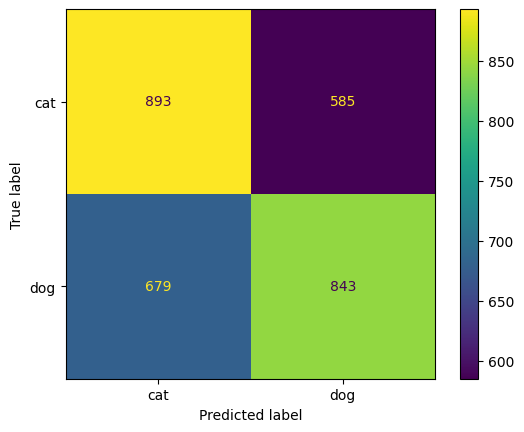

In [ ]:
# train model
m5svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m5svm = get_features_m5svm(test_images)
print(features_test_m5svm.shape)

(1000, 80000)


In [ ]:
# get model predictions
predictions_m5svm = m5svm.predict(features_test_m5svm)
#print(predictions_m5svm)

**M6: Adaptive Histogram Equalization (AHE) + Flatten**

In [ ]:
import cv2
import numpy as np
from skimage import exposure

# method to get image features
def get_features_m6svm(images):

  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization for better contrast
    img_ahe = exposure.equalize_adapthist(img_grayscaled, clip_limit=0.03)

    # Flatten and store features
    features = img_ahe.flatten()
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m6svm = get_features_m6svm(train_images)
print(features_train_m6svm.shape)

(10000, 40000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m6svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5193333333333333


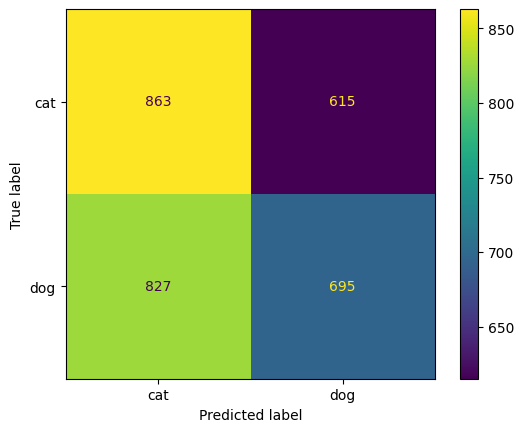

In [ ]:
# Train model
m6svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m6svm = get_features_m6svm(test_images)
print(features_test_m6svm.shape)

(1000, 40000)


In [ ]:
# Get model predictions
predictions_m6svm = m6svm.predict(features_test_m6svm)
#print(predictions_m6svm)

**M7: Sobel Edge Detection + Grayscale (SVM)**

In [ ]:
# method to get image features
def get_features_m7svm(images):

  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Sobel Edge Detection (Gradient in x and y directions)
    sobelx = cv2.Sobel(img_grayscaled, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img_grayscaled, cv2.CV_64F, 0, 1, ksize=5)

    # Flatten and concatenate features
    features = np.hstack((sobelx.flatten(), sobely.flatten()))
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m7svm = get_features_m7svm(train_images)
print(features_train_m7svm.shape)

(10000, 80000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m7svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5156666666666667


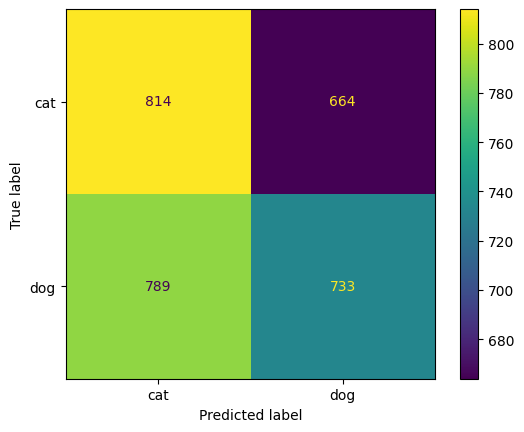

In [ ]:
# Train model
m7svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m7svm = get_features_m7svm(test_images)
print(features_test_m7svm.shape)

(1000, 80000)


In [ ]:
# Get model predictions
predictions_m7svm = m7svm.predict(features_test_m7svm)
#print(predictions_m7svm)

**M8: Laplacian Edge Detection + Blurring**

In [ ]:
# method to get image features
def get_features_m8svm(images):
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    img_blurred = cv2.GaussianBlur(img_grayscaled, (3,3), 2)

    # Apply Laplacian Edge Detection
    laplacian = cv2.Laplacian(img_blurred, cv2.CV_64F)

    # Flatten features
    features = laplacian.flatten()
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m8svm = get_features_m8svm(train_images)
print(features_train_m8svm.shape)

(10000, 40000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m8svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.509


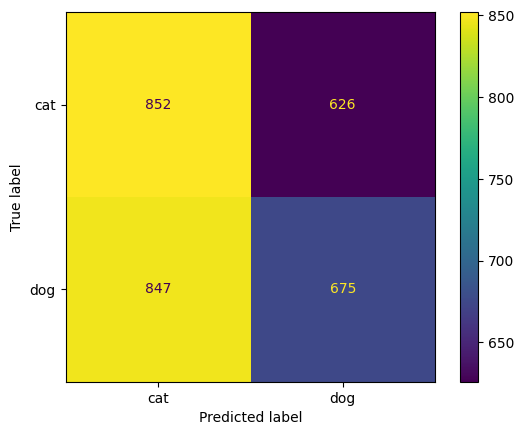

In [ ]:
# Train model
m8svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m8svm = get_features_m8svm(test_images)
print(features_test_m8svm.shape)

(1000, 40000)


In [ ]:
# Get model predictions
predictions_m8svm = m8svm.predict(features_test_m8svm)
#print(predictions_m8svm)

**M9: Combination of Features (Grayscale + HOG + Canny Edges) (SVM)**

In [ ]:
# method to get image features
def get_features_m9svm(images):
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image for HOG feature extraction
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # Apply HOG feature extraction
    hog_features, _ = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=True)

    # Apply Canny Edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)

    # Concatenate grayscale, HOG, and Canny Edge features
    features1 = img_grayscaled.flatten()
    features2 = hog_features.flatten()
    features3 = edges_canny.flatten()

    features = np.hstack((features1, features2, features3))
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m9svm = get_features_m9svm(train_images)
print(features_train_m9svm.shape)

(10000, 83780)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m9svm, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5786666666666667


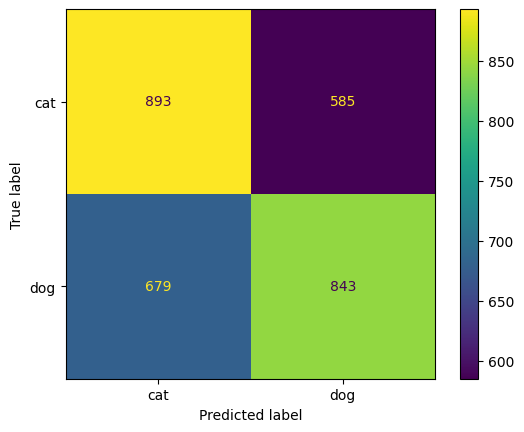

In [ ]:
# Train model
m9svm = get_svm_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m9svm = get_features_m9svm(test_images)
print(features_test_m9svm.shape)




(1000, 83780)


In [ ]:
# Get model predictions
predictions_m9svm = m9svm.predict(features_test_m9svm)
#print(predictions_m9svm)

**M10 HOG-based Feature Extraction and PCA for Image Classification (SVM)**

In [ ]:
# Method to extract HOG features from images
def get_features_m10svm(images):
    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_m10svm = get_features_m10svm(train_images)
print("Feature shape before PCA:", features_train_m10svm.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_m10svm = pca.fit_transform(features_train_m10svm)
print("Feature shape after PCA:", features_train_pca_m10svm.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_m10svm, df_train['label'],
                                                  test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.685


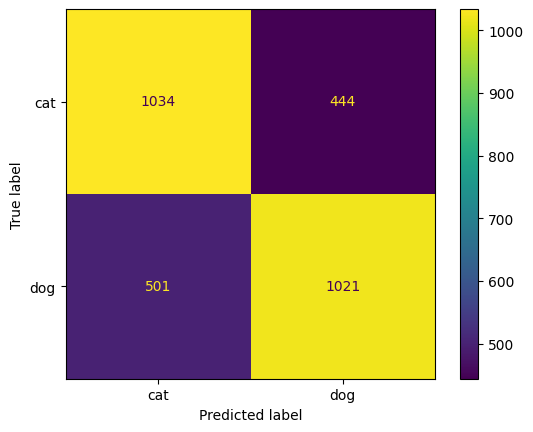

In [ ]:
# Train the model with the PCA-transformed data
m10svm = get_svm_predictions(X_train, X_val, y_train, y_val)

**M11 Hyper Parameters tunning on HOG-based Feature Extraction and PCA for Image Classification (SVM)**

In [ ]:
# Method to extract HOG features from images
def get_features_m11svm(images):
    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_m11svm = get_features_m11svm(train_images)
print("Feature shape before PCA:", features_train_m11svm.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_m11svm = pca.fit_transform(features_train_m11svm)

print("Feature shape after PCA:", features_train_pca_m11svm.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_m11svm, df_train['label'],
                                                  test_size=0.3, random_state=42)

In [ ]:
# Define the SVM model
svm_model = SVC()

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.7374285714285714


In [ ]:
# Train the best SVM model with optimal hyperparameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

SVC(C=10)

In [ ]:
# Evaluate on validation set
val_accuracy = best_svm.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.743


**M12 Best Parameters on HOG-based Feature Extraction and PCA for Image Classification (SVM)**

In [ ]:
# Method to train and predict using optimized SVM classifier
def get_svm_predictionsBp(X_train, X_val, y_train, y_val):
    # Build model with best parameters from tuning
    clf = svm.SVC(C=10, kernel='rbf', gamma='scale', random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)

    # Make predictions on validation data
    y_pred = clf.predict(X_val)

    # Evaluate performance
    evaluate(y_val, y_pred, clf.classes_)

    return clf

In [ ]:
# Method to extract HOG features from images
def get_features_SvmBp(images):
    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_SvmBp = get_features_SvmBp(train_images)
print("Feature shape before PCA:", features_train_SvmBp.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_SvmBp = pca.fit_transform(features_train_SvmBp)
print("Feature shape after PCA:", features_train_pca_SvmBp.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_SvmBp, df_train['label'],
                                                  test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.7406666666666667


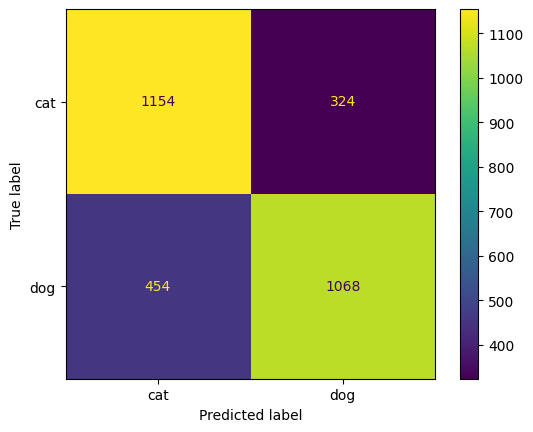

In [ ]:
# Train the model with the PCA-transformed data
SvmBp = get_svm_predictionsBp(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_SvmBp= get_features_SvmBp(test_images)
print(features_test_SvmBp.shape)

(1000, 3780)


In [ ]:
# Apply the same PCA transformation used during training
features_test_pca_SvmBp = pca.transform(features_test_SvmBp)  # Transform test features with fitted PCA
print(features_test_pca_SvmBp.shape)

(1000, 994)


In [ ]:
# Get model predictions using the transformed test data
predictions_SvmBp = SvmBp.predict(features_test_pca_SvmBp)
#print(predictions_m4SvmPCA)

* Save Prediction

In [ ]:
# # Feature extraction - test data
# features_test = get_features_m1svm(test_images)
# print("Test features shape:", features_test.shape)

# # Get model predictions
# predictions = m1svm.predict(features_test)
predictions_SvmBp = SvmBp.predict(features_test_pca_SvmBp)
# print("Predictions sample:", predictions[:10])
print("Predictions sample:", predictions_SvmBp[:10])


# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': df_test['id'],    # The test image ids
    'label': predictions_SvmBp     # The predicted labels
})

# Preview the submission
print(submission_df.head())

# Save to CSV
submission_df.to_csv('submission_m1svm.csv', index=False)
print("Submission file saved as submission_m1svm.csv")

Predictions sample: ['dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'cat' 'cat' 'dog']
   id label
0   1   dog
1   2   cat
2   3   cat
3   4   cat
4   5   dog
Submission file saved as submission_m1svm.csv


In [ ]:
# Get value counts of predictions
prediction_counts = pd.Series(predictions_SvmBp).value_counts()
print("\nPrediction Value Counts:")
print(prediction_counts)


Prediction Value Counts:
cat    514
dog    486
Name: count, dtype: int64


**2.0. FUNCTION: Train & Predict using Random Forest**

In [ ]:
# Method to train and predict using default Random Forest classifier
def get_rf_predictions(X_train, X_val, y_train, y_val):
    # Build Random Forest model with default parameters
    clf = RandomForestClassifier(random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)

    # Make predictions on validation data
    y_pred = clf.predict(X_val)

    # Evaluate performance
    evaluate(y_val, y_pred, np.unique(y_train))

    return clf

**MODEL 1: Grayscale Image Vectorization (Rf)**

In [ ]:
# method to get image features
def get_features_m1rf(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # image vectorisation/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m1rf = get_features_m1rf(train_images)
print(features_train_m1rf.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m1rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6073333333333333


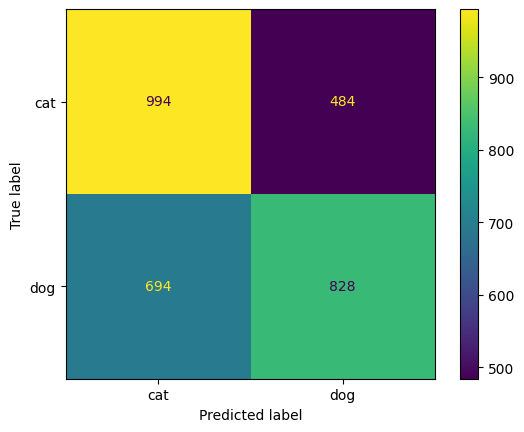

In [ ]:
# train model
m1rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m1rf = get_features_m1rf(test_images)
print(features_test_m1rf.shape)

# get model predictions
predictions_m1rf = m1rf.predict(features_test_m1rf)
#print(predictions_m1rf)

(1000, 40000)


**M2: Grayscale + Smoothing (Gaussian Blur) (RF)**

In [ ]:
# method to get image features
def get_features_m2rf(images):
  features_list = []
  for img in images:
    # image preprocessing - gray scaling + smoothing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled, (3,3), 2)

    # image vectorisation/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m2rf = get_features_m2rf(train_images)
print(features_train_m2rf.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m2rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.61


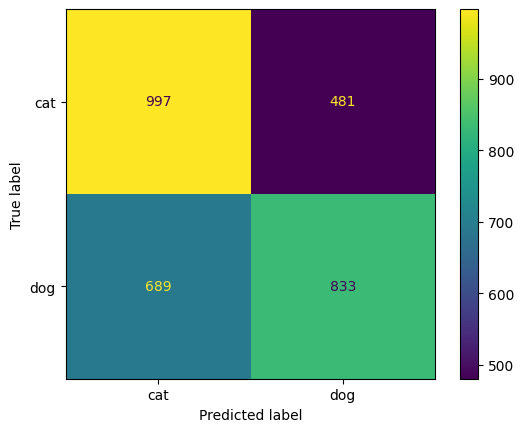

In [ ]:
# train model
m2rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m2rf = get_features_m2rf(test_images)
print(features_test_m2rf.shape)

(1000, 40000)


In [ ]:
# get model predictions
predictions_m2rf = m2rf.predict(features_test_m2rf)
#print(predictions_m2rf)

**M3: Grayscale + Edge Detection (Canny) (RF)**

In [ ]:
# method to get image features
def get_features_m3rf(images):
  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction - edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m3rf = get_features_m3rf(train_images)
print(features_train_m3rf.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m3rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5866666666666667


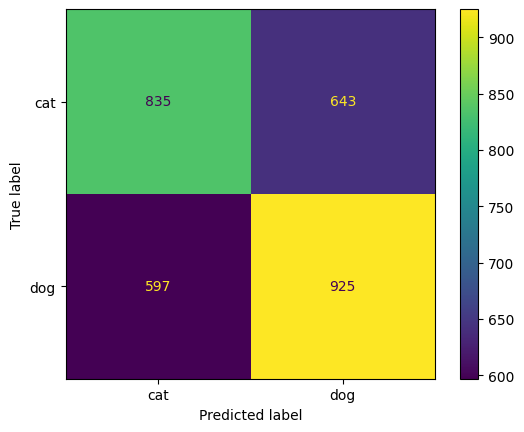

In [ ]:
# train model
m3rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m3rf = get_features_m3rf(test_images)
print(features_test_m3rf.shape)

(1000, 40000)


In [ ]:
# get model predictions
predictions_m3rf = m3rf.predict(features_test_m3rf)
#print(predictions_m3rf)

**M4: Grayscale + HOG Features (RF)**

In [ ]:
from skimage.feature import hog

# method to get image features
def get_features_m4rf(images):
  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction - HOG
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m4rf = get_features_m4rf(train_images)
print(features_train_m4rf.shape)

(10000, 3780)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m4rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.701


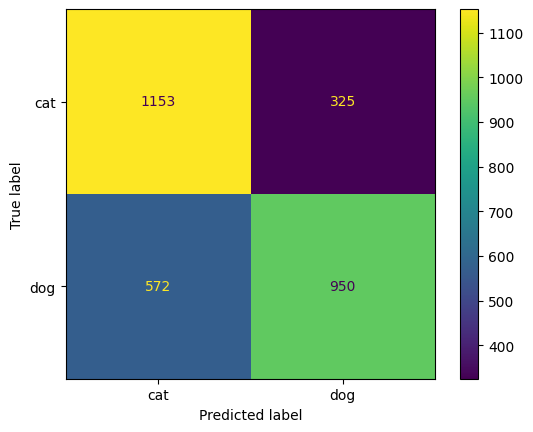

In [ ]:
# train model
m4rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m4rf = get_features_m4rf(test_images)
print(features_test_m4rf.shape)

(1000, 3780)


In [ ]:
# get model predictions
predictions_m4rf = m4rf.predict(features_test_m4rf)
#print(predictions_m4rf)

**M5: Grayscale + Edge Detection + Original Image Features (Concatenation) (RF)**

In [ ]:
# method to get image features
def get_features_m5rf(images):
  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction - edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)

    # Combine both grayscale features and edge detection features
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m5rf = get_features_m5rf(train_images)
print(features_train_m5rf.shape)

(10000, 80000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m5rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6326666666666667


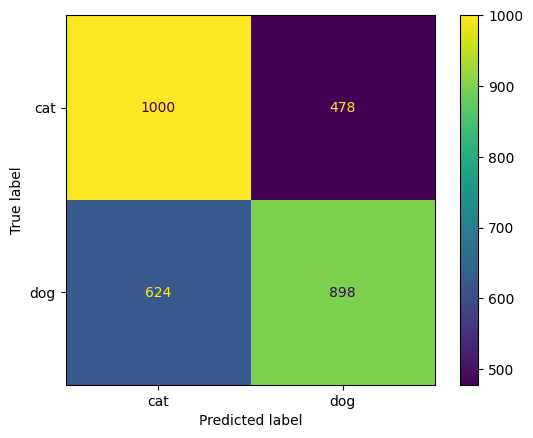

In [ ]:
# train model
m5rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m5rf = get_features_m5rf(test_images)
print(features_test_m5rf.shape)

(1000, 80000)


In [ ]:
# get model predictions
predictions_m5rf = m5rf.predict(features_test_m5rf)
#print(predictions_m5rf)

**M6: Adaptive Histogram Equalization (AHE) + Flatten (RF)**

In [ ]:
# method to get image features
def get_features_m6rf(images):
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization for better contrast
    img_ahe = exposure.equalize_adapthist(img_grayscaled, clip_limit=0.03)

    # Flatten and store features
    features = img_ahe.flatten()
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m6rf = get_features_m6rf(train_images)
print(features_train_m6rf.shape)

(10000, 40000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m6rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.572


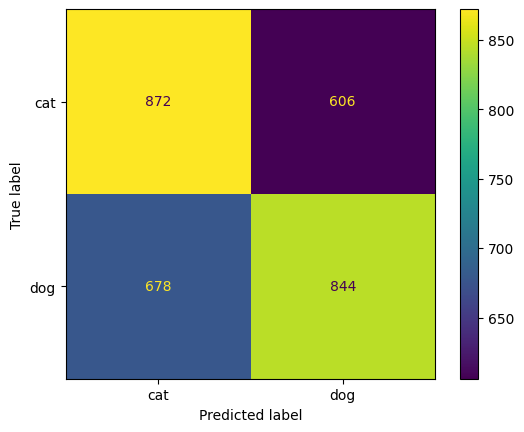

In [ ]:
# Train model
m6rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m6rf = get_features_m6rf(test_images)
print(features_test_m6rf.shape)

(1000, 40000)


In [ ]:
# Get model predictions
predictions_m6rf = m6rf.predict(features_test_m6rf)
#print(predictions_m6rf)

**M7: Sobel Edge Detection + Grayscale (RF)**

In [ ]:
# method to get image features
def get_features_m7rf(images):
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Sobel Edge Detection (Gradient in x and y directions)
    sobelx = cv2.Sobel(img_grayscaled, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img_grayscaled, cv2.CV_64F, 0, 1, ksize=5)

    # Flatten and concatenate features
    features = np.hstack((sobelx.flatten(), sobely.flatten()))
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m7rf = get_features_m7rf(train_images)
print(features_train_m7rf.shape)

(10000, 80000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m7rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6336666666666667


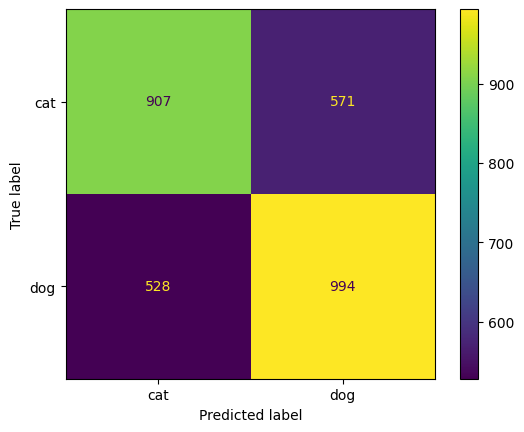

In [ ]:
# Train model
m7rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m7rf = get_features_m7rf(test_images)
print(features_test_m7rf.shape)

(1000, 80000)


In [ ]:
# Get model predictions
predictions_m7rf = m7rf.predict(features_test_m7rf)
#print(predictions_m7rf)

**M8: Laplacian Edge Detection + Blurring (RF)**

In [ ]:
# method to get image features
def get_features_m8rf(images):
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    img_blurred = cv2.GaussianBlur(img_grayscaled, (3,3), 2)

    # Apply Laplacian Edge Detection
    laplacian = cv2.Laplacian(img_blurred, cv2.CV_64F)

    # Flatten features
    features = laplacian.flatten()
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m8rf = get_features_m8rf(train_images)
print(features_train_m8rf.shape)

(10000, 40000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m8rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6036666666666667


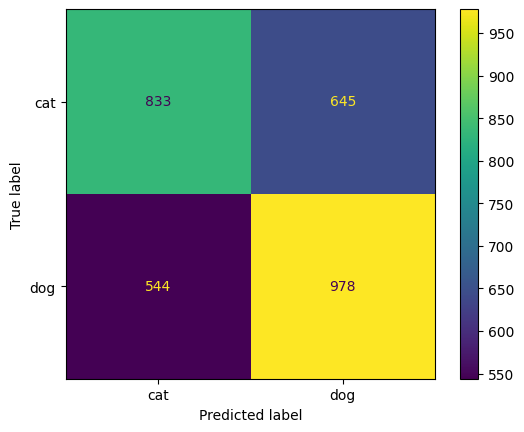

In [ ]:
# Train model
m8rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m8rf = get_features_m8rf(test_images)
print(features_test_m8rf.shape)

(1000, 40000)


In [ ]:
# Get model predictions
predictions_m8rf = m8rf.predict(features_test_m8rf)
#print(predictions_m8rf)

**M9: Combination of Features (Grayscale + HOG + Canny Edges) (RF)**

In [ ]:
# method to get image features
def get_features_m9rf(images):
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image for HOG feature extraction
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # Apply HOG feature extraction
    hog_features, _ = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=True)

    # Apply Canny Edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)

    # Concatenate grayscale, HOG, and Canny Edge features
    features1 = img_grayscaled.flatten()
    features2 = hog_features.flatten()
    features3 = edges_canny.flatten()

    features = np.hstack((features1, features2, features3))
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m9rf = get_features_m9rf(train_images)
print(features_train_m9rf.shape)

(10000, 83780)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m9rf, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6763333333333333


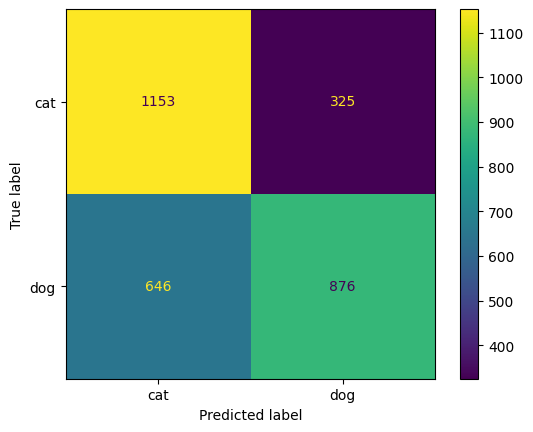

In [ ]:
# Train model
m9rf = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m9rf = get_features_m9rf(test_images)
print(features_test_m9rf.shape)

(1000, 83780)


In [ ]:
# Get model predictions
predictions_m9rf = m9rf.predict(features_test_m9rf)
#print(predictions_m9rf)

**M10 HOG-based Feature Extraction and PCA for Image Classification**

In [ ]:
# Method to extract HOG features from images
def get_features_m10rfPCA(images):

    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_m10rfPCA = get_features_m10rfPCA(train_images)
print("Feature shape before PCA:", features_train_m10rfPCA.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_m10rfPCA = pca.fit_transform(features_train_m10rfPCA)
print("Feature shape after PCA:", features_train_pca_m10rfPCA.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_m10rfPCA, df_train['label'],
                                                  test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6656666666666666


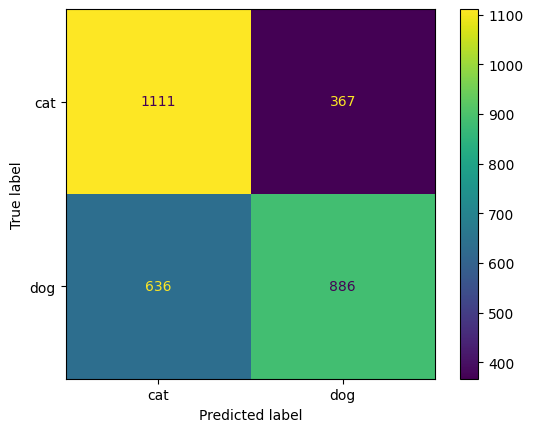

In [ ]:
# Train the model with the PCA-transformed data
m10rfPCA = get_rf_predictions(X_train, X_val, y_train, y_val)

**M11 Hyper Parameters tunning on HOG-based Feature Extraction and PCA for Image Classification (RF)**

In [ ]:
# Method to extract HOG features from images
def get_features_m11rf(images):

    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_m11rf = get_features_m11rf(train_images)
print("Feature shape before PCA:", features_train_m11rf.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_m11rf = pca.fit_transform(features_train_m11rf)

print("Feature shape after PCA:", features_train_pca_m11rf.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_m11rf, df_train['label'],
                                                  test_size=0.3, random_state=42)

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameters to tune (reduced search space)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Perform Randomized Search Cross Validation
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,                  # Number of random combinations to try
    cv=3,                       # Reduce cross-validation folds to 3
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model on training data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}
Best Accuracy: 0.6919999466198684


In [ ]:
# Train the best Random Forest model with optimal hyperparameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=300, random_state=42)

In [ ]:
# Evaluate on validation set
val_accuracy = best_rf.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.6946666666666667


**M12 Best Parameters on HOG-based Feature Extraction and PCA for Image Classification**

In [ ]:
# Method to train and predict using optimized SVM classifier
def get_rf_predictionsBp(X_train, X_val, y_train, y_val):
    # Build model with best parameters from tuning
    clf = RandomForestClassifier(
        bootstrap=False,
        max_depth=10,
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=300,
        random_state=42  # or RANDOM_SEED if you prefer
    )
    clf.fit(X_train, y_train)

    # Make predictions on validation data
    y_pred = clf.predict(X_val)

    # Evaluate performance
    evaluate(y_val, y_pred, clf.classes_)

    return clf

In [ ]:
# Method to extract HOG features from images
def get_features_m12rfBp(images):

    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_m12rfBp = get_features_m12rfBp(train_images)
print("Feature shape before PCA:", features_train_m12rfBp.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_m12rfBp = pca.fit_transform(features_train_m12rfBp)
print("Feature shape after PCA:", features_train_pca_m12rfBp.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_m12rfBp, df_train['label'],
                                                  test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6943333333333334


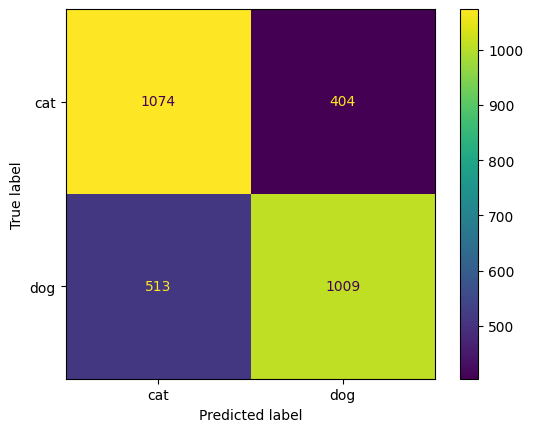

In [ ]:
# Train the model with the PCA-transformed data
rfBp = get_rf_predictionsBp(X_train, X_val, y_train, y_val)

**2.0. FUNCTION: Train & Predict using Decision Tree Classifier**

In [ ]:
 # Method to train and predict using default Decision Tree classifier
def get_dt_predictions(X_train, X_val, y_train, y_val):
    # Build Decision Tree model with default parameters
    clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)

    # Make predictions on validation data
    y_pred = clf.predict(X_val)

    # Evaluate performance
    evaluate(y_val, y_pred, np.unique(y_train))

    return clf

**MODEL 1: Grayscale Image Vectorization (DT)**

In [ ]:
# method to get image features
def get_features_m1dt(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # image vectorisation/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m1dt = get_features_m1dt(train_images)
print(features_train_m1dt.shape)

(10000, 40000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m1dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5616666666666666


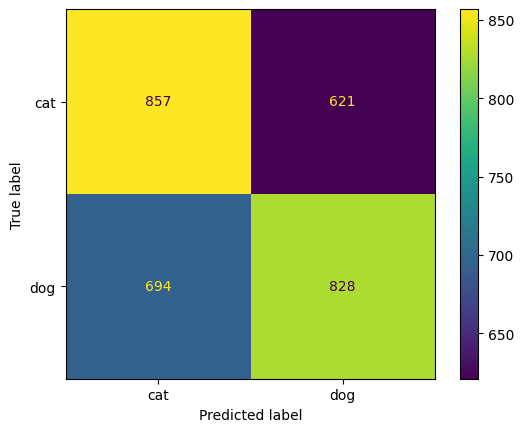

In [ ]:
# train model
m1dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m1dt = get_features_m1dt(test_images)
print(features_test_m1dt.shape)

# get model predictions
predictions_m1dt = m1dt.predict(features_test_m1dt)
#print(predictions_m1dt)

(1000, 40000)


 **M2: Grayscale + Smoothing (Gaussian Blur) (DT)**

In [ ]:
# method to get image features
def get_features_m2dt(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling + smoothing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled, (3,3), 2)

    # image vectorisation/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m2dt = get_features_m2dt(train_images)
print(features_train_m2dt.shape)

(10000, 3780)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m2dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.543


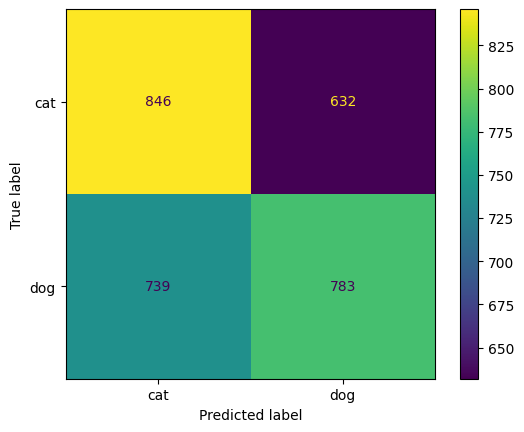

In [ ]:
# train model
m2dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m2dt = get_features_m2dt(test_images)
print(features_test_m2dt.shape)

(1000, 40000)


In [ ]:
# get model predictions
predictions_m2dt = m2dt.predict(features_test_m2dt)
#print(predictions_m2dt)

**M3: Grayscale + Edge Detection (Canny) (DT)**

In [ ]:
# method to get image features
def get_features_m3dt(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction - edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m3dt = get_features_m3dt(train_images)
print(features_train_m3dt.shape)

(10000, 3780)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m3dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.533


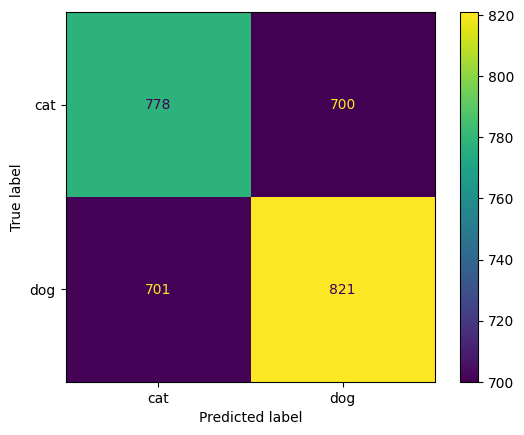

In [ ]:
# train model
m3dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m3dt = get_features_m3dt(test_images)
print(features_test_m3dt.shape)

(1000, 40000)


In [ ]:
# get model predictions
predictions_m3dt = m3dt.predict(features_test_m3dt)
#print(predictions)

**M4: Grayscale + HOG Features (RF)**

In [ ]:
from skimage.feature import hog

# method to get image features
def get_features_m4dt(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction - HOG
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m4dt = get_features_m4dt(train_images)
print(features_train_m4dt.shape)

(10000, 3780)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m4dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.592


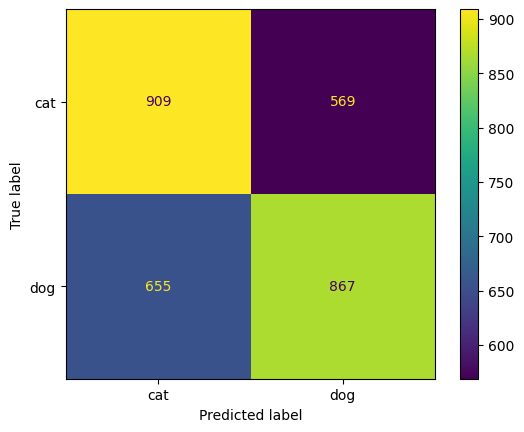

In [ ]:
# train model
m4dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m4dt = get_features_m4dt(test_images)
print(features_test_m4dt.shape)

(1000, 3780)


In [ ]:
# get model predictions
predictions_m4dt = m4dt.predict(features_test_m4dt)
#print(predictions)

**M5: Grayscale + Edge Detection + Original Image Features (Concatenation) (DT)**

In [ ]:
# method to get image features
def get_features_m5dt(images):

  features_list = []
  for img in images:
    # image preprocessing - gray scaling
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction - edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)

    # Combine both grayscale features and edge detection features
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# feature extraction
features_train_m5dt = get_features_m5dt(train_images)
print(features_train_m5dt.shape)

(10000, 80000)


In [ ]:
# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_m5dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5496666666666666


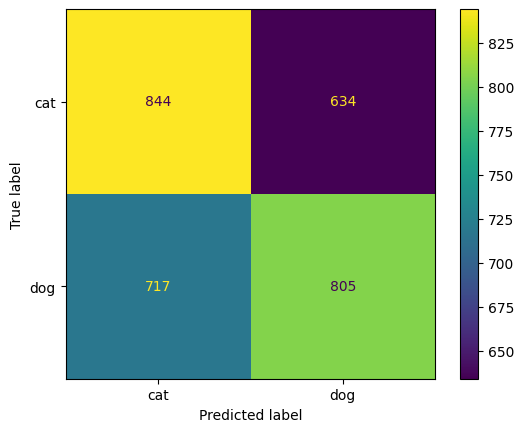

In [ ]:
# train model
m5dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# feature extraction - test data
features_test_m5dt = get_features_m5dt(test_images)
print(features_test_m5dt.shape)

(1000, 80000)


In [ ]:
# get model predictions
predictions_m5dt = m5dt.predict(features_test_m5dt)
#print(predictions)

**M6: Adaptive Histogram Equalization (AHE) + Flatten (DT)**

In [ ]:
# method to get image features
def get_features_m6dt(images):
  '''
  images: list of images
  '''
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization for better contrast
    img_ahe = exposure.equalize_adapthist(img_grayscaled, clip_limit=0.03)

    # Flatten and store features
    features = img_ahe.flatten()
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m6dt = get_features_m6dt(train_images)
print(features_train_m6dt.shape)

(10000, 40000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m6dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.525


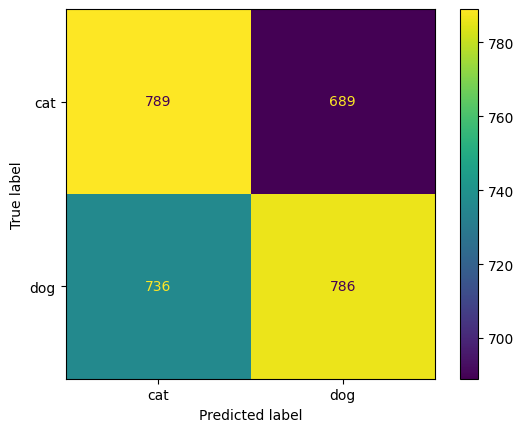

In [ ]:
# Train model
m6dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m6dt = get_features_m6dt(test_images)
print(features_test_m6dt.shape)

(1000, 40000)


In [ ]:
# Get model predictions
predictions_m6dt = m6dt.predict(features_test_m6dt)
#print(predictions)

**M7: Sobel Edge Detection + Grayscale (RF)**

In [ ]:
# method to get image features
def get_features_m7dt(images):

  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Sobel Edge Detection (Gradient in x and y directions)
    sobelx = cv2.Sobel(img_grayscaled, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img_grayscaled, cv2.CV_64F, 0, 1, ksize=5)

    # Flatten and concatenate features
    features = np.hstack((sobelx.flatten(), sobely.flatten()))
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m7dt = get_features_m7dt(train_images)
print(features_train_m7dt.shape)

(10000, 80000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m7dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.54


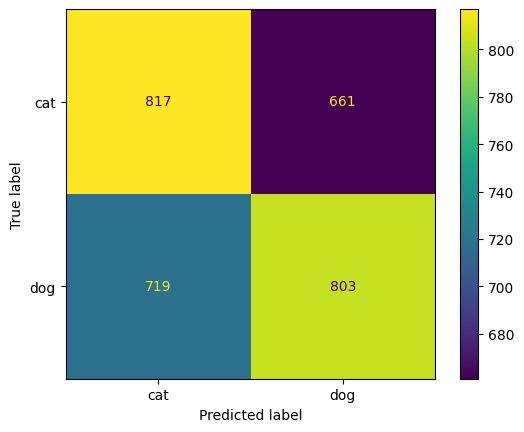

In [ ]:
# Train model
m7dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m7dt = get_features_m7dt(test_images)
print(features_test_m7dt.shape)

(1000, 80000)


In [ ]:
# Get model predictions
predictions_m7dt = m7dt.predict(features_test_m7dt)
#print(predictions)

**M8: Laplacian Edge Detection + Blurring (DT)**

In [ ]:
# method to get image features
def get_features_m8dt(images):
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    img_blurred = cv2.GaussianBlur(img_grayscaled, (3,3), 2)

    # Apply Laplacian Edge Detection
    laplacian = cv2.Laplacian(img_blurred, cv2.CV_64F)

    # Flatten features
    features = laplacian.flatten()
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m8dt = get_features_m8dt(train_images)
print(features_train_m8dt.shape)

(10000, 40000)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m8dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.535


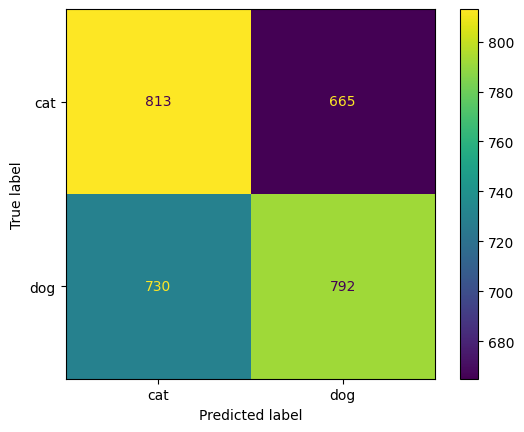

In [ ]:
# Train model
m8dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m8dt = get_features_m8dt(test_images)
print(features_test_m8dt.shape)

(1000, 40000)


In [ ]:
# Get model predictions
predictions_m8dt = m8dt.predict(features_test_m8dt)
#print(predictions)

**M9: Combination of Features (Grayscale + HOG + Canny Edges) (DT)**

In [ ]:
# method to get image features
def get_features_m9dt(images):
  features_list = []
  for img in images:
    # Convert to grayscale
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image for HOG feature extraction
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # Apply HOG feature extraction
    hog_features, _ = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=True)

    # Apply Canny Edge detection
    edges_canny = cv2.Canny(img_grayscaled, 100, 200)

    # Concatenate grayscale, HOG, and Canny Edge features
    features1 = img_grayscaled.flatten()
    features2 = hog_features.flatten()
    features3 = edges_canny.flatten()

    features = np.hstack((features1, features2, features3))
    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

In [ ]:
# Feature extraction
features_train_m9dt = get_features_m9dt(train_images)
print(features_train_m9dt.shape)

(10000, 83780)


In [ ]:
# Data split
X_train, X_val, y_train, y_val = train_test_split(features_train_m9dt, df_train['label'], test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.5756666666666667


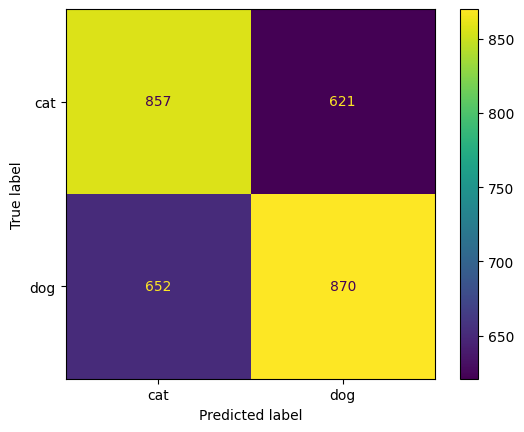

In [ ]:
# Train model
m9dt = get_dt_predictions(X_train, X_val, y_train, y_val)

In [ ]:
# Feature extraction - test data
features_test_m9dt = get_features_m9dt(test_images)
print(features_test_m9dt.shape)

(1000, 83780)


In [ ]:
# Get model predictions
predictions_m9dt = m9dt.predict(features_test_m9dt)
#print(predictions)

**M10 HOG-based Feature Extraction and PCA for Image Classification (DT)**

In [ ]:
# Method to extract HOG features from images
def get_features_m10dtPCA(images):

    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_m10dtPCA = get_features_m10dtPCA(train_images)
print("Feature shape before PCA:", features_train_m10dtPCA.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_m10dtPCA = pca.fit_transform(features_train_m10dtPCA)
print("Feature shape after PCA:", features_train_pca_m10dtPCA.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_m10dtPCA, df_train['label'],
                                                  test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.588


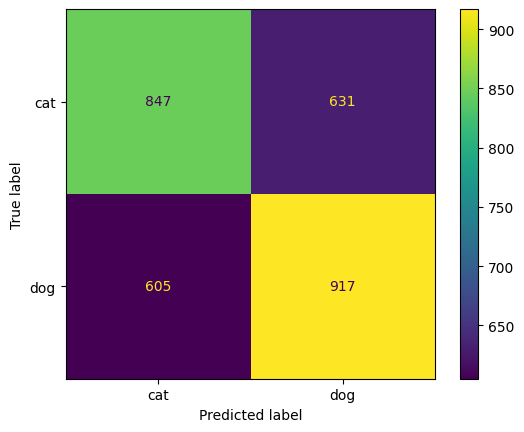

In [ ]:
# Train the model with the PCA-transformed data
m10rfPCA = get_dt_predictions(X_train, X_val, y_train, y_val)

**M11 Hyper Parameters tunning on HOG-based Feature Extraction and PCA for Image Classification (DT)**

In [ ]:
# Method to extract HOG features from images
def get_features_m11dtHp(images):

    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_m11dtHp = get_features_m11dtHp(train_images)
print("Feature shape before PCA:", features_train_m11dtHp.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_m11dtHp = pca.fit_transform(features_train_m11dtHp)

print("Feature shape after PCA:", features_train_pca_m11dtHp.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_m11dtHp, df_train['label'],
                                                  test_size=0.3, random_state=42)

In [ ]:
# Define the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Accuracy: 0.6514285714285715


In [ ]:
# Create and train the best Decision Tree model with optimal hyperparameters
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, random_state=42)

In [ ]:
# Evaluate on validation set
val_accuracy = best_dt.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.6376666666666667


**M12 Best Parameters on HOG-based Feature Extraction and PCA for Image Classification (DT)**

In [ ]:
# Method to train and predict using optimized Decision Tree classifier
def get_dt_predictionsm12dtBp(X_train, X_val, y_train, y_val):
    # Build model with best parameters
    clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on validation data
    y_pred = clf.predict(X_val)

    # Evaluate performance
    evaluate(y_val, y_pred, clf.classes_)

    return clf

In [ ]:
# Method to extract HOG features from images
def get_features_dt12Bp(images):

    features_list = []

    for img in images:
        # Convert image to grayscale
        img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize image to ensure uniform shape
        img_resized = cv2.resize(img_grayscaled, (64, 128))

        # Extract HOG features
        features = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        features_list.append(features)

    return np.array(features_list)

In [ ]:
# Extract features from training images
features_train_dt12Bp = get_features_dt12Bp(train_images)
print("Feature shape before PCA:", features_train_dt12Bp.shape)

Feature shape before PCA: (10000, 3780)


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features_train_pca_dt12Bp = pca.fit_transform(features_train_dt12Bp)
print("Feature shape after PCA:", features_train_pca_dt12Bp.shape)

Feature shape after PCA: (10000, 994)


In [ ]:
# Split data for training and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_pca_dt12Bp, df_train['label'],
                                                  test_size=0.3, random_state=RANDOM_SEED)

Accuracy: 0.6026666666666667


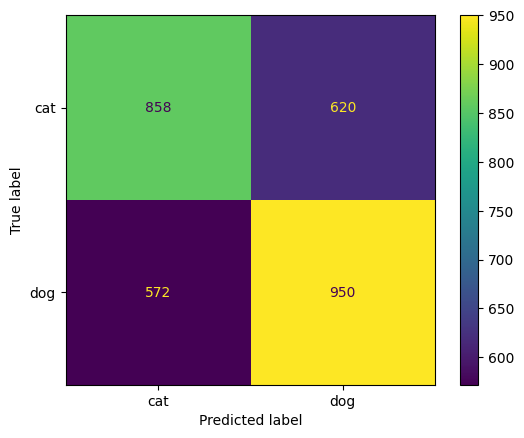

In [ ]:
# Train the model with the PCA-transformed data
dtBp = get_dt_predictionsm12dtBp(X_train, X_val, y_train, y_val)

**Save Prediction**

In [ ]:
# # Feature extraction - test data
# features_test = get_features_m1svm(test_images)
# print("Test features shape:", features_test.shape)

# # Get model predictions
# predictions = m1svm.predict(features_test)
# print("Predictions sample:", predictions[:10])

In [ ]:



# # Create a submission DataFrame
# submission_df = pd.DataFrame({
#     'id': df_test['id'],    # The test image ids
#     'label': predictions     # The predicted labels
# })

# # Preview the submission
# print(submission_df.head())

# # Save to CSV
# submission_df.to_csv('submission_m1svm.csv', index=False)
# print("Submission file saved as submission_m1svm.csv")

**Deep Learning Model**

* **Data Preprocessing**

Images are resized and reshaped to include the required channel dimension for compatibility with Convolutional Neural Networks (CNNs).

* Preprocessing

In [ ]:
df_train['filename'] = df_train['id'].astype(str) + '.jpg'
df_test['filename'] = df_test['id'].astype(str) + '.jpg'

train_data, val_data = train_test_split(df_train, test_size=0.2, stratify=df_train['label'])

* Data Augmentation & Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_data, train_image_folder, x_col='filename', y_col='label',
    target_size=img_size, class_mode='binary', batch_size=batch_size
)

val_gen = val_datagen.flow_from_dataframe(
    val_data, train_image_folder, x_col='filename', y_col='label',
    target_size=img_size, class_mode='binary', batch_size=batch_size
)

test_gen = val_datagen.flow_from_dataframe(
    df_test, test_image_folder, x_col='filename',
    y_col=None, target_size=img_size, class_mode=None, shuffle=False, batch_size=batch_size
)


Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


* Optimized CNN Architecture for Image Classification

In [ ]:
img_height, img_width, img_channels = 150, 150, 3

cnn_model = tf.keras.Sequential([
    layers.Input(shape=(img_height, img_width, img_channels)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,037,121 (72.62 MB)

 Trainable params: 19,035,649 (72.62 MB)

 Non-trainable params: 1,472 (5.75 KB)

* Learning Rate Scheduler & Callbacks

In [ ]:
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 10:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)


* Compile Model

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


* Class Weights (Optional if Dataset is Imbalanced)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_data['label']),
                                     y=train_data['label'])

class_weight_dict = dict(enumerate(class_weights))


* Train the Model (With Callbacks & Class Weights)

In [ ]:
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[lr_scheduler, early_stop, reduce_lr],
    class_weight=class_weight_dict  # Remove this line if the classes are balanced
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 286ms/step - accuracy: 0.5742 - loss: 1.0252 - val_accuracy: 0.5440 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.6338 - loss: 0.6717 - val_accuracy: 0.5095 - val_loss: 1.1252 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.6690 - loss: 0.6202 - val_accuracy: 0.6815 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.7042 - loss: 0.5773 - val_accuracy: 0.7285 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 278ms/step - accuracy: 0.7279 - loss: 0.5473 - val_accuracy: 0.7400 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.7341 - loss: 0.5282 - val_accuracy: 0.7145 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 278ms/step - accuracy: 0.7

* Plot Training Metrics

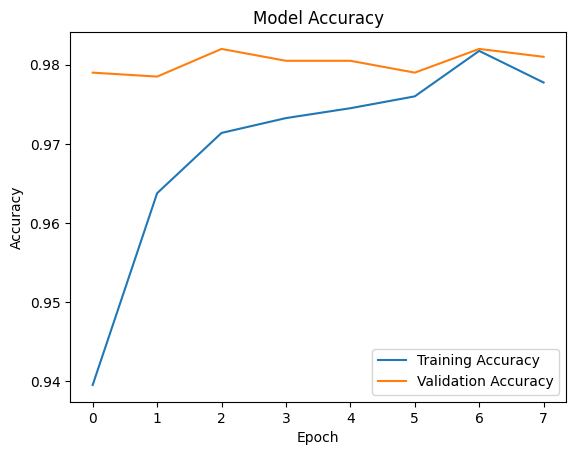

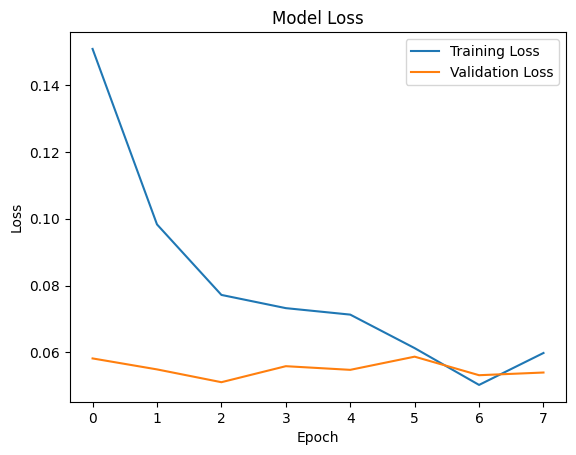

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


*  Predict on Test Set (Optional)

In [ ]:
predictions = cnn_model.predict(test_gen)
predictions = (predictions > 0.5).astype(int)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step


* Evaluate on Validation Set

In [ ]:
val_loss, val_accuracy = cnn_model.evaluate(val_gen)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8826 - loss: 0.2912
Validation Loss: 0.2893158793449402
Validation Accuracy: 0.8799999952316284


**Transfer Learning with Pre-trained CNN (MobileNetV2)**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# Clear session to free memory
keras.backend.clear_session()

# set random seed
random_seed = 100  # Example integer value
keras.utils.set_random_seed(random_seed)


* Import Required Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
base_dim = (224, 224)  # Updated to the correct input size for the model

# load train images
train_image_folder = os.path.join(data_folder, 'train_images')
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = os.path.join(data_folder, 'test_images')
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

100%|██████████| 10000/10000 [00:50<00:00, 196.62it/s]


Number of training images loaded: 10000


100%|██████████| 1000/1000 [00:05<00:00, 192.34it/s]

Number of testing images loaded: 1000


*  Set Important Parameters

In [ ]:
# Image size for MobileNetV2 (must be 224x224)
IMG_SIZE = (224, 224)

# Batch size
BATCH_SIZE = 32


* Load and Prepare Image Data

*Convert images to numpy arrays + float32*

In [ ]:
# Convert images to numpy arrays and normalize (0-1 range)
train_images = np.array(train_images, dtype=np.float32) / 255.0

# Confirm shape: should be (num_samples, height, width, 3)
print(f"Train images shape: {train_images.shape}")


Train images shape: (10000, 224, 224, 3)


*Encode labels*

In [ ]:
# Encode labels (binary: 0 and 1)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_train['label'].values)

# Confirm shape and dtype
labels = np.array(labels, dtype=np.float32)
print(f"Labels shape: {labels.shape}")


Labels shape: (10000,)


*Train-Validation Split*

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (8000, 224, 224, 3)
Validation data shape: (2000, 224, 224, 3)


* Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./1.,  # Already rescaled manually (if not, use 1./255)
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./1.  # Already rescaled manually (or use 1./255 if needed)
)

# Create generators
train_gen = train_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE
)

val_gen = val_datagen.flow(
    X_val,
    y_val,
    batch_size=BATCH_SIZE
)


* Build the Transfer Learning Model with MobileNetV2

In [ ]:
# Load MobileNetV2 base model (without top layers)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Final classification layer for binary classification
predictions = Dense(1, activation='sigmoid')(x)

# Define the complete model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Show model summary
transfer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,916,417 (11.13 MB)

 Trainable params: 657,409 (2.51 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

* Compile the Model

In [ ]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


* Add Callbacks

In [ ]:
# Reduce learning rate if validation accuracy stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Stop early if no improvement
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


* Train the Model

In [ ]:
history = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 328ms/step - accuracy: 0.8910 - loss: 0.2469 - val_accuracy: 0.9790 - val_loss: 0.0582 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 310ms/step - accuracy: 0.9664 - loss: 0.0874 - val_accuracy: 0.9785 - val_loss: 0.0549 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 309ms/step - accuracy: 0.9725 - loss: 0.0714 - val_accuracy: 0.9820 - val_loss: 0.0511 - learning_rate: 1.0000e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 307ms/step - accuracy: 0.9727 - loss: 0.0748 - val_accuracy: 0.9805 - val_loss: 0.0559 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 307ms/step - accuracy: 0.9751 - loss: 0.0673 - val_accuracy: 0.9805 - val_loss: 0.0548 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9782 - loss: 0.0587
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 305ms/s

* Plot Training Curves

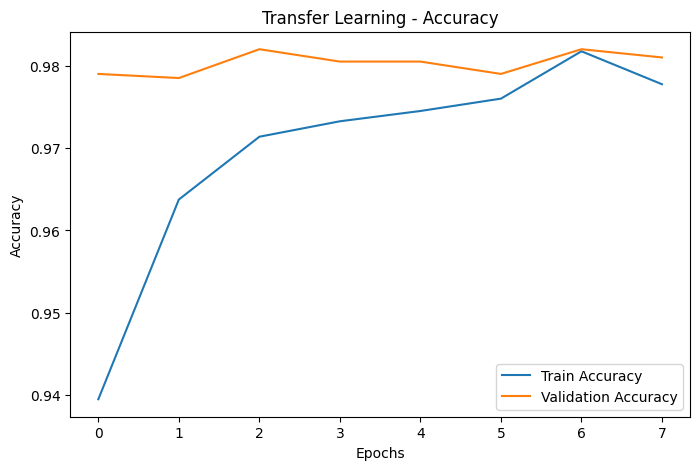

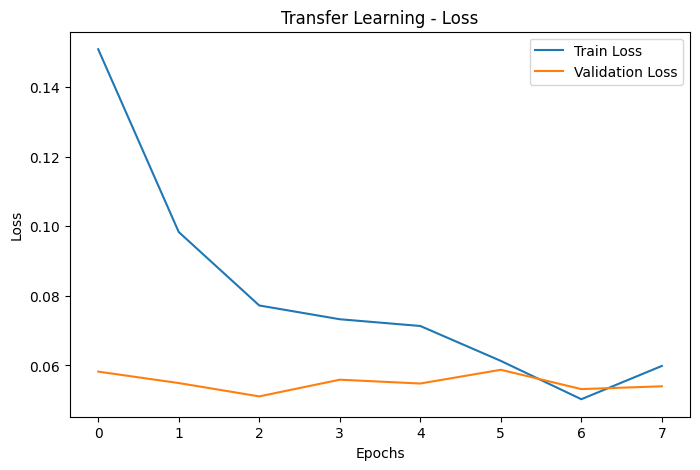

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


* Predict on Test Set

In [ ]:
# Assuming you have test_images (list of images)
test_images = np.array(test_images, dtype=np.float32) / 255.0

# Resize if necessary: (num_samples, 224, 224, 3)
x_test_resized = test_images

# Predict probabilities
predictions = transfer_model.predict(x_test_resized)

# Convert probabilities to binary labels
predictions = (predictions > 0.5).astype(int).flatten()

# Map labels back if necessary
df_test['label'] = predictions
df_test['label'] = df_test['label'].map({1: 'dog', 0: 'cat'})

# Save submission
df_test[['id', 'label']].to_csv('submission_transfer_learning.csv', index=False)

print("Submission file saved successfully.")


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step
Submission file saved successfully.
